# Off-line comparison of KF2, KF3 and KF4 algorithms ( Filtering )

A high-speed IBG (IMU + Baro+GPS) data log was recorded while moving the gps-vario up and down. An IBG data log contains IMU AHRS data recorded at 500 samples/sec, Baro z-altitude data at 50 samples/sec and (if available) GPS data at 10 samples/sec. 

This sample log was obtained indoors without GPS reception as we are only interested in testing the Kalman Filtering algorithms that uses altitude and gravity-compensated acceleration data to estimate altitude and climb/sink rate.

An MS5611 barometric pressure sensor and MPU9250 9-DOF IMU generated the sensor data. 

The offline algorithm comparison code was compiled and executed in an Ubuntu 20.04 terminal.

In `config.h` choose the algorithm to run and set LOG_INPUT_OUTPUT to 1.

E.g. if you want to run the KF2 algorithm,
```
// choose one of the following tests
// print the kalman filter P convergence over first 512 samples of data
#define LOG_CONVERGENCE    0
// print the baro sensor derived altitude cm, and kalman filter estimates for z and v, for all samples
#define LOG_INPUT_OUTPUT   1

// choose one of the following algorithms  
// for LOG_CONVERGENCE run, only KF3 and KF4 are valid
#define USE_KF2 1
#define USE_KF3 0
#define USE_KF4 0
```
Build the code :
```
g++ -o kf_compare kf_compare.cpp kalmanfilter2.cpp kalmanfilter3.cpp kalmanfilter4.cpp imu.cpp ringbuf.cpp -lm
```
Generate the results :
```
./kf_compare ./ms5611_datalog > kf2_ms5611_inout.txt
```

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
z = []
z_kf2 = []
v_kf2 = []
with open('kf2_ms5611_inout.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z.append(float(row[0]))
        z_kf2.append(float(row[1]))
        v_kf2.append(float(row[2]))
z = np.array(z)        
z_kf2 = np.array(z_kf2)
v_kf2 = np.array(v_kf2)        

In [3]:
z_kf3 = []
v_kf3 = []
with open('kf3_ms5611_inout.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z_kf3.append(float(row[1]))
        v_kf3.append(float(row[2]))
z_kf3 = np.array(z_kf3)
v_kf3 = np.array(v_kf3)        

In [4]:
z_kf4 = []
v_kf4 = []
with open('kf4_ms5611_inout.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z_kf4.append(float(row[1]))
        v_kf4.append(float(row[2]))
z_kf4 = np.array(z_kf4)
v_kf4 = np.array(v_kf4)   

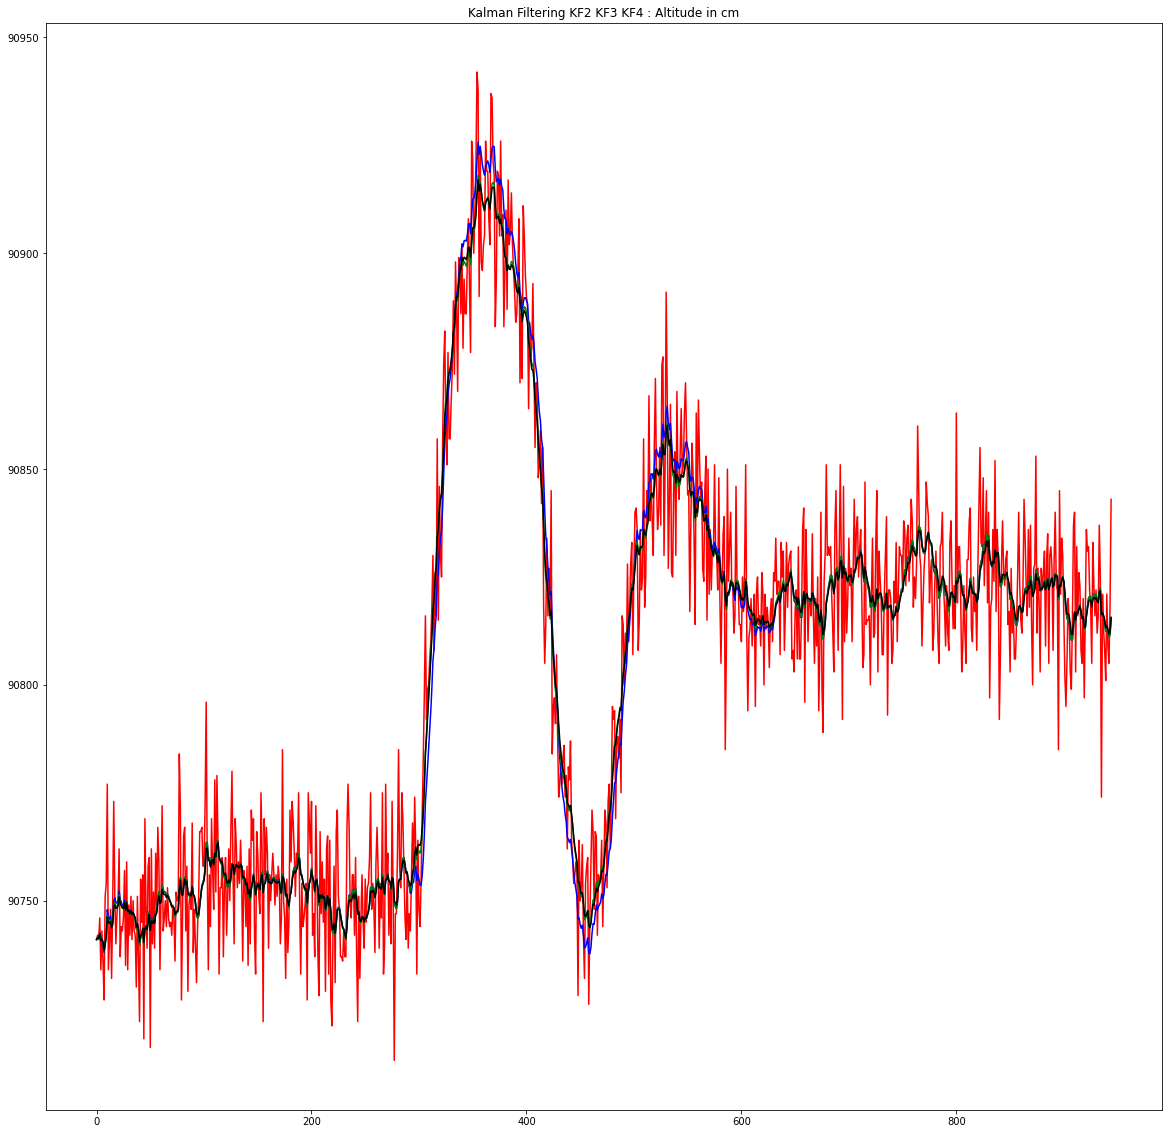

In [5]:
# enlarge the plot size to show more detail
plt.rcParams["figure.figsize"]=20,20

# Plot the MS5611 barometric pressure sensor derived altitude samples in red
plt.plot(z, color='red')

# KF2 filter only uses the altitude samples
plt.plot(z_kf2, color='blue')

# KF3 filter fuses altitude and gravity-compensated acceleration data
plt.plot(z_kf3, color='green')

# KF4 filter fuses altitude and gravity-compensated acceleration data
plt.plot(z_kf4, color='black')

plt.title('Kalman Filtering KF2 KF3 KF4 : Altitude in cm')
plt.show()

## Zoomed in window

KF2 shows a response lag, while KF3 and KF4 do not

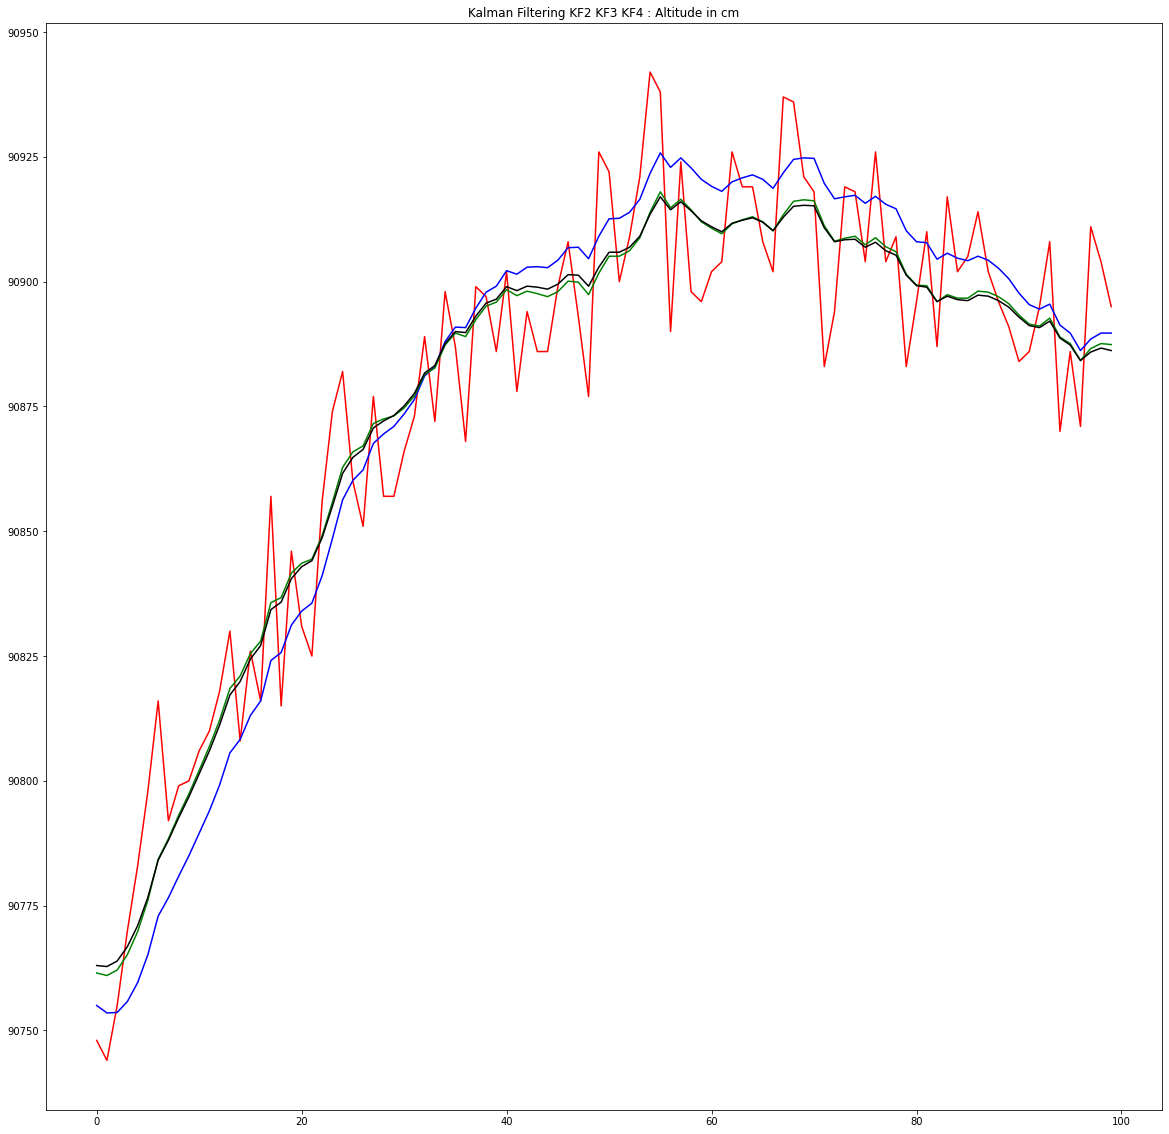

In [6]:
plt.plot(z[300:400], color='red')
plt.plot(z_kf2[300:400], color='blue')
plt.plot(z_kf3[300:400], color='green')
plt.plot(z_kf4[300:400], color='black')
plt.title('Kalman Filtering KF2 KF3 KF4 : Altitude in cm')
plt.show()

# Climb/sink rate estimation

The KF2 filter lag is clearly visible even without zooming in. The difference is very perceptible for variometer audio feedback.

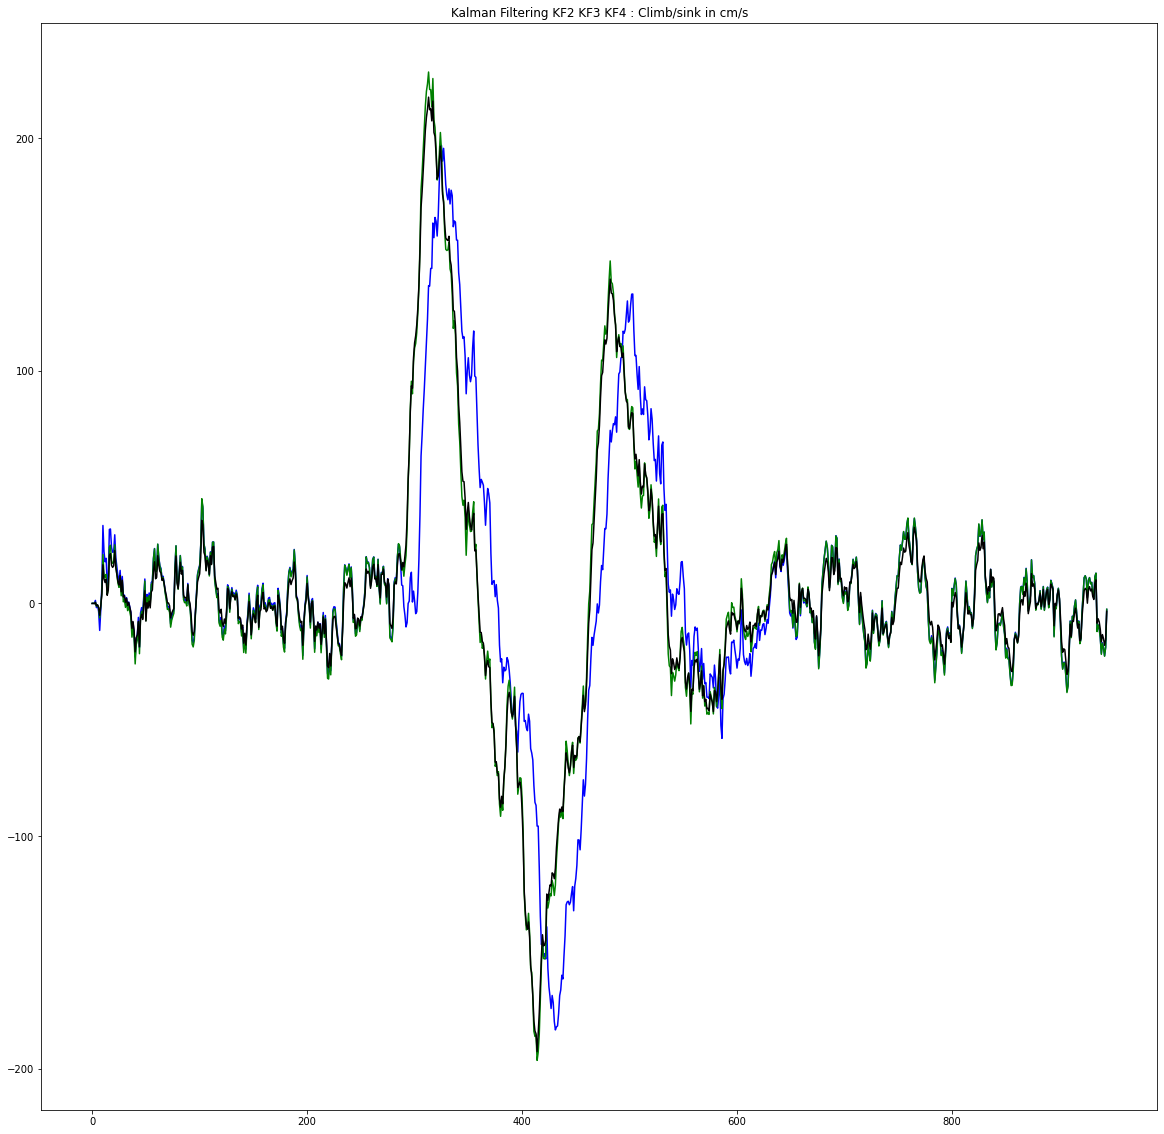

In [7]:
plt.plot(v_kf2, color='blue')
plt.plot(v_kf3, color='green')
plt.plot(v_kf4, color='black')
plt.title('Kalman Filtering KF2 KF3 KF4 : Climb/sink in cm/s')
plt.show()

When zoomed in, we can quantify the difference in response. The sample interval is 20mS. KF2 responds to the falling variometer nearly 0.5 seconds later. This demonstrates the benefit of fusing acceleration and altitude readings for minimum-lag variometer response.

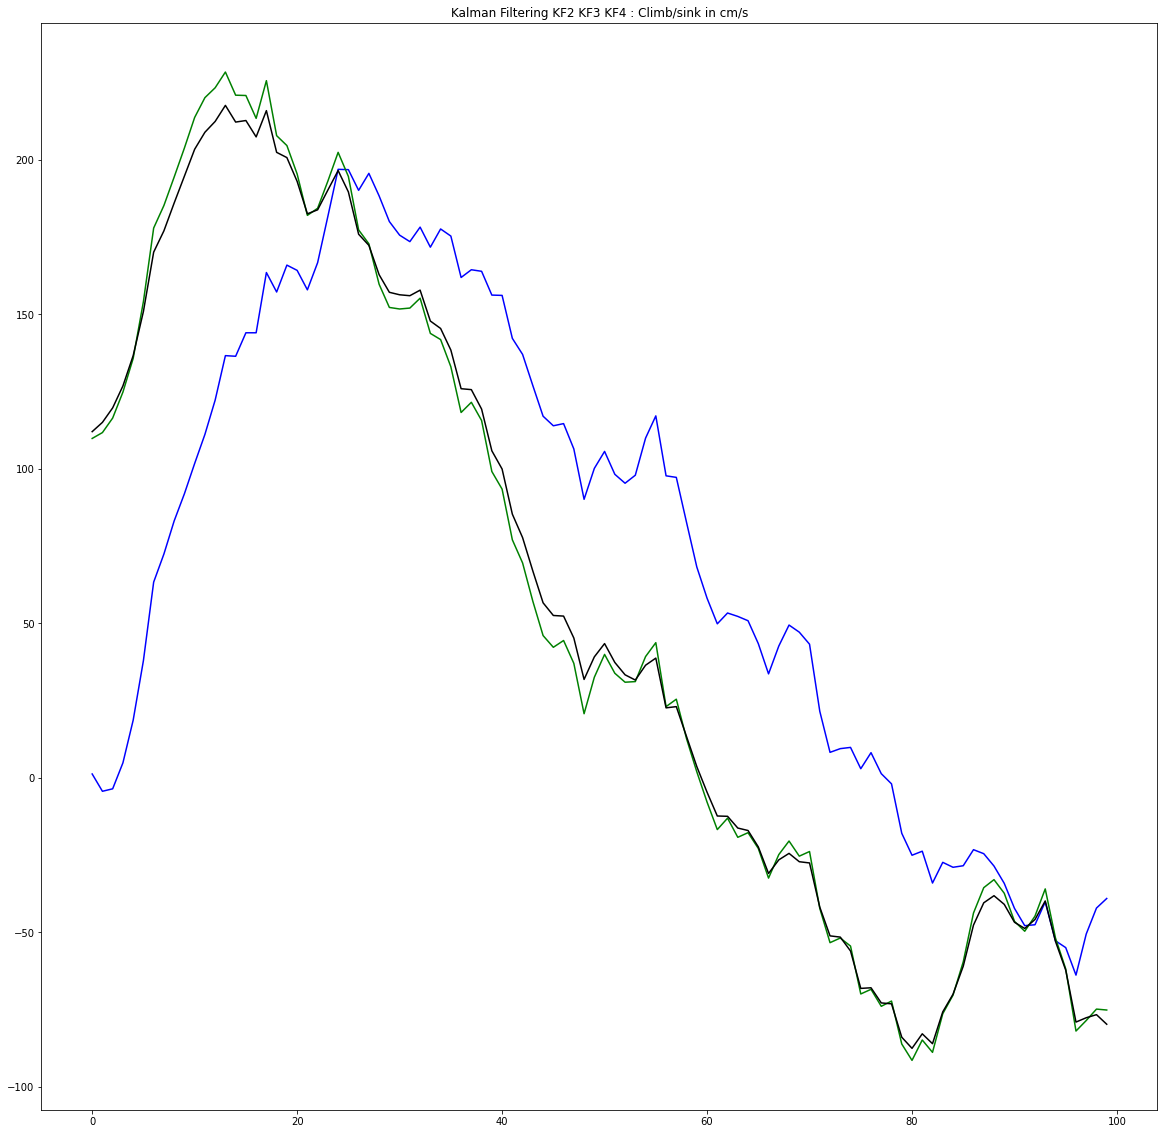

In [8]:
plt.plot(v_kf2[300:400], color='blue')
plt.plot(v_kf3[300:400], color='green')
plt.plot(v_kf4[300:400], color='black')
plt.title('Kalman Filtering KF2 KF3 KF4 : Climb/sink in cm/s')
plt.show()

# Off-line comparison of KF3 and KF4 algorithms (P convergence)

In `config.h` choose the algorithm to run and set LOG_CONVERGENCE to 1.

E.g. if you want to check the KF3 algorithm convergence,
```
// choose one of the following tests
// print the kalman filter P convergence over first 512 samples of data
#define LOG_CONVERGENCE    1
// print the baro sensor derived altitude cm, and kalman filter estimates for z and v, for all samples
#define LOG_INPUT_OUTPUT   0

// choose one of the following algorithms  
// for LOG_CONVERGENCE run, only KF3 and KF4 are valid
#define USE_KF2 0
#define USE_KF3 1
#define USE_KF4 0
```
Build the code :
```
g++ -o kf_compare kf_compare.cpp kalmanfilter2.cpp kalmanfilter3.cpp kalmanfilter4.cpp imu.cpp ringbuf.cpp -lm
```
Generate the results :
```
./kf_compare ./ms5611_datalog > kf3_ms5611_convergence.txt
```

In [9]:
z_kf3 = []
Pzz_kf3 = []
v_kf3 = []
Pvv_kf3 = []
with open('kf3_ms5611_convergence.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    line = 0
    for row in csvreader:
        line = line+1
        # first two lines have log documentation
        if line > 2:
            z_kf3.append(float(row[0]))
            Pzz_kf3.append(float(row[1]))
            v_kf3.append(float(row[2]))
            Pvv_kf3.append(float(row[3]))
z_kf3 = np.array(z_kf3)        
Pzz_kf3 = np.array(Pzz_kf3)
v_kf3 = np.array(v_kf3)        
Pvv_kf3 = np.array(Pvv_kf3)

In [10]:
z_kf4 = []
Pzz_kf4 = []
v_kf4 = []
Pvv_kf4 = []
with open('kf4_ms5611_convergence.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    line = 0
    for row in csvreader:
        line = line+1
        # first two lines have log documentation
        if line > 2:
            z_kf4.append(float(row[0]))
            Pzz_kf4.append(float(row[1]))
            v_kf4.append(float(row[2]))
            Pvv_kf4.append(float(row[3]))
z_kf4 = np.array(z_kf4)        
Pzz_kf4 = np.array(Pzz_kf4)
v_kf4 = np.array(v_kf4)        
Pvv_kf4 = np.array(Pvv_kf4)

# Pzz convergence

Compare KF3 and KF4 altitude uncertainty convergence for the first 512 filter output samples

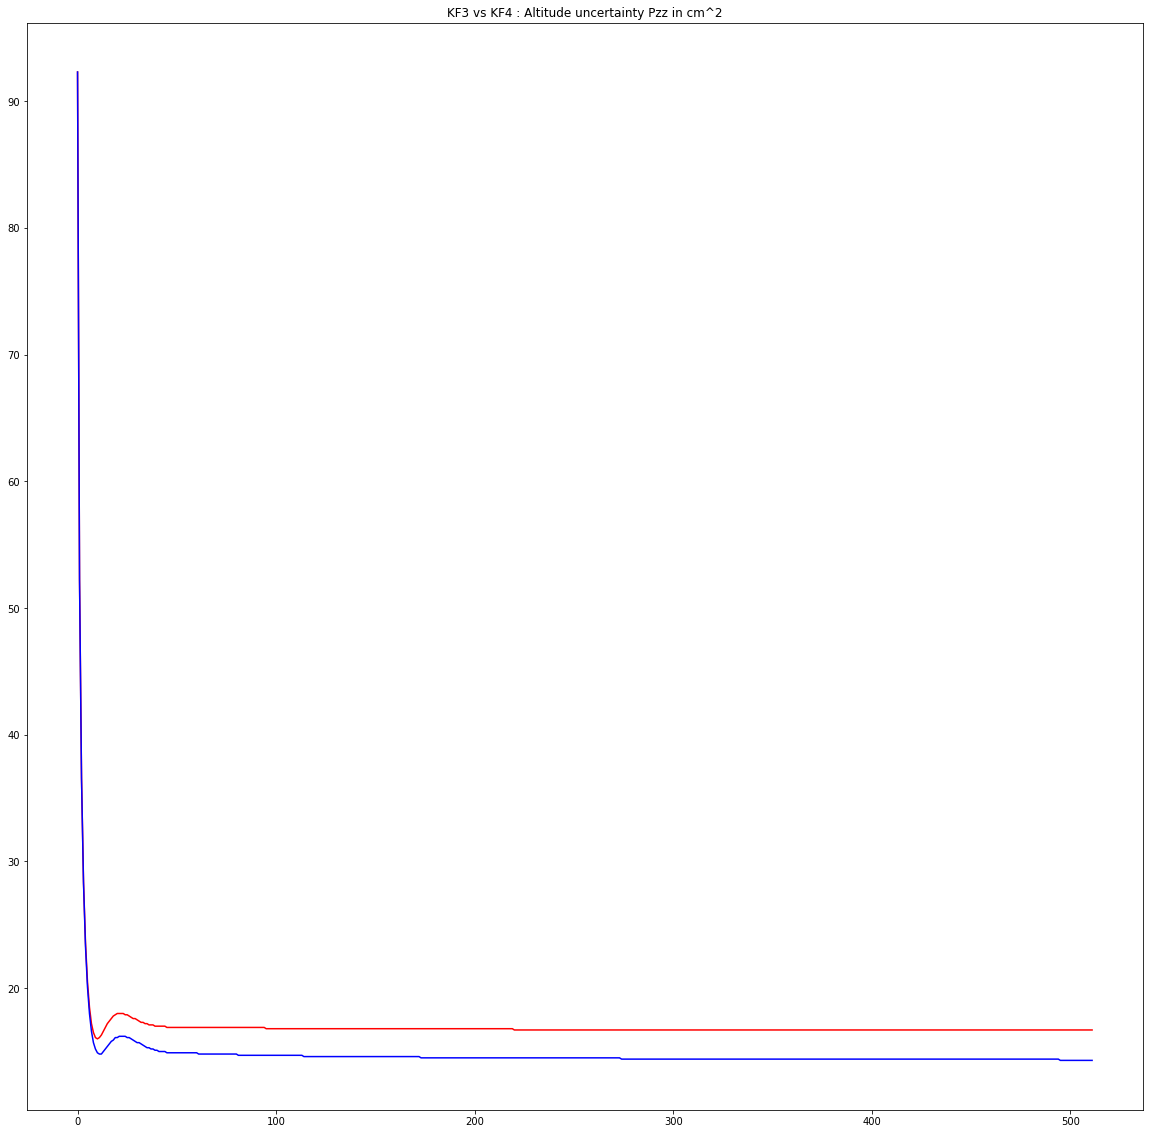

In [11]:
plt.plot(Pzz_kf3, color='red')
plt.plot(Pzz_kf4, color='blue')
plt.title('KF3 vs KF4 : Altitude uncertainty Pzz in cm^2')
plt.show()

Steep drop at start, so re-plot at starting offset 5 so that the difference in converged levels is clearer

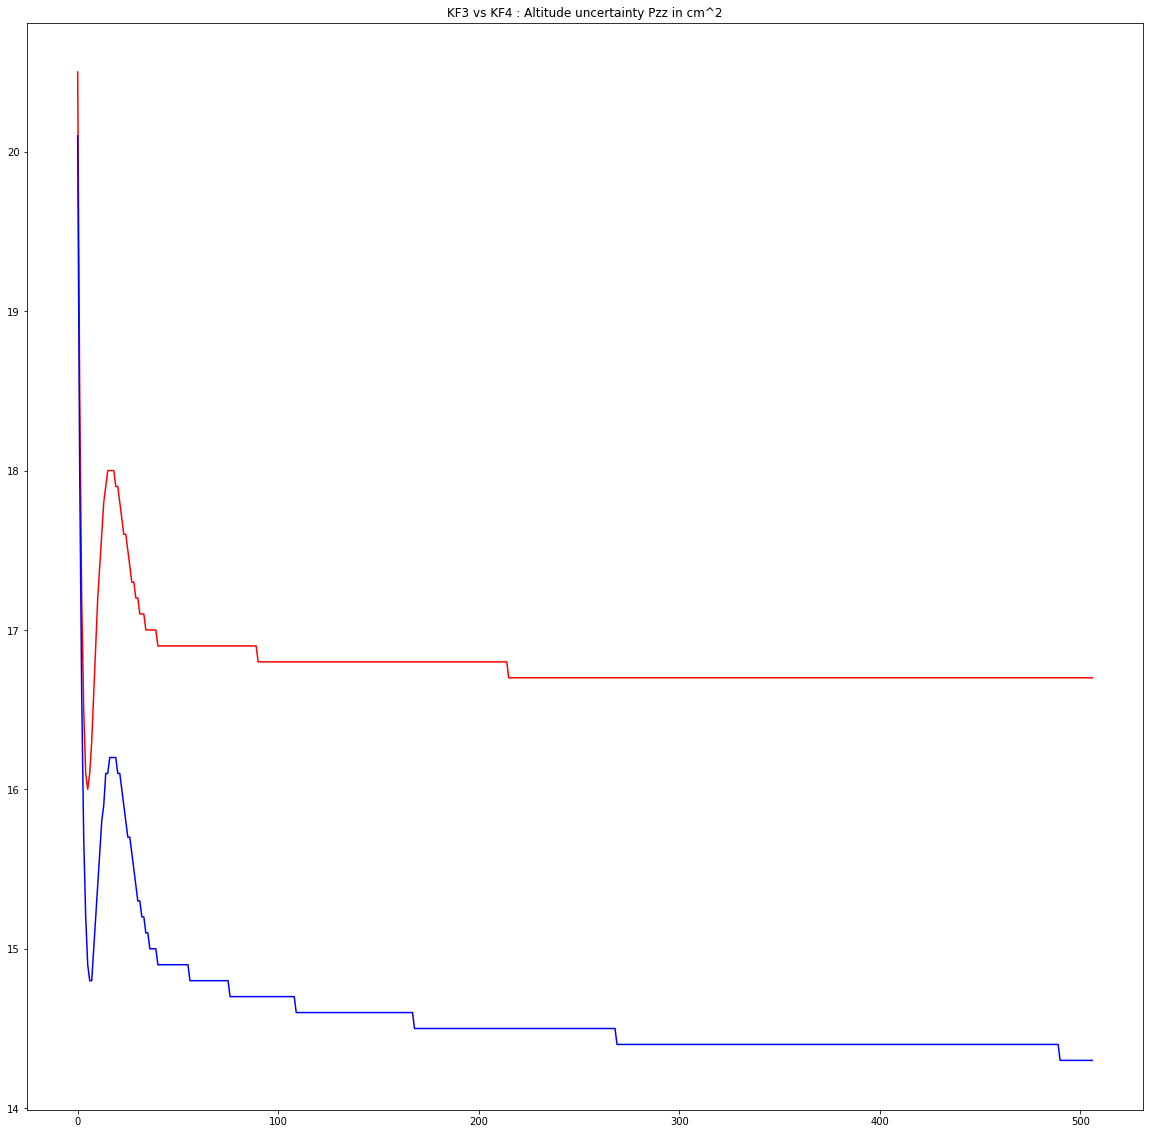

In [12]:
plt.plot(Pzz_kf3[5:512], color='red')
plt.plot(Pzz_kf4[5:512], color='blue')
plt.title('KF3 vs KF4 : Altitude uncertainty Pzz in cm^2')
plt.show()

# Pvv convergence

Compare KF3 and KF4 climb/sink rate uncertainty convergence for first 512 filter output samples

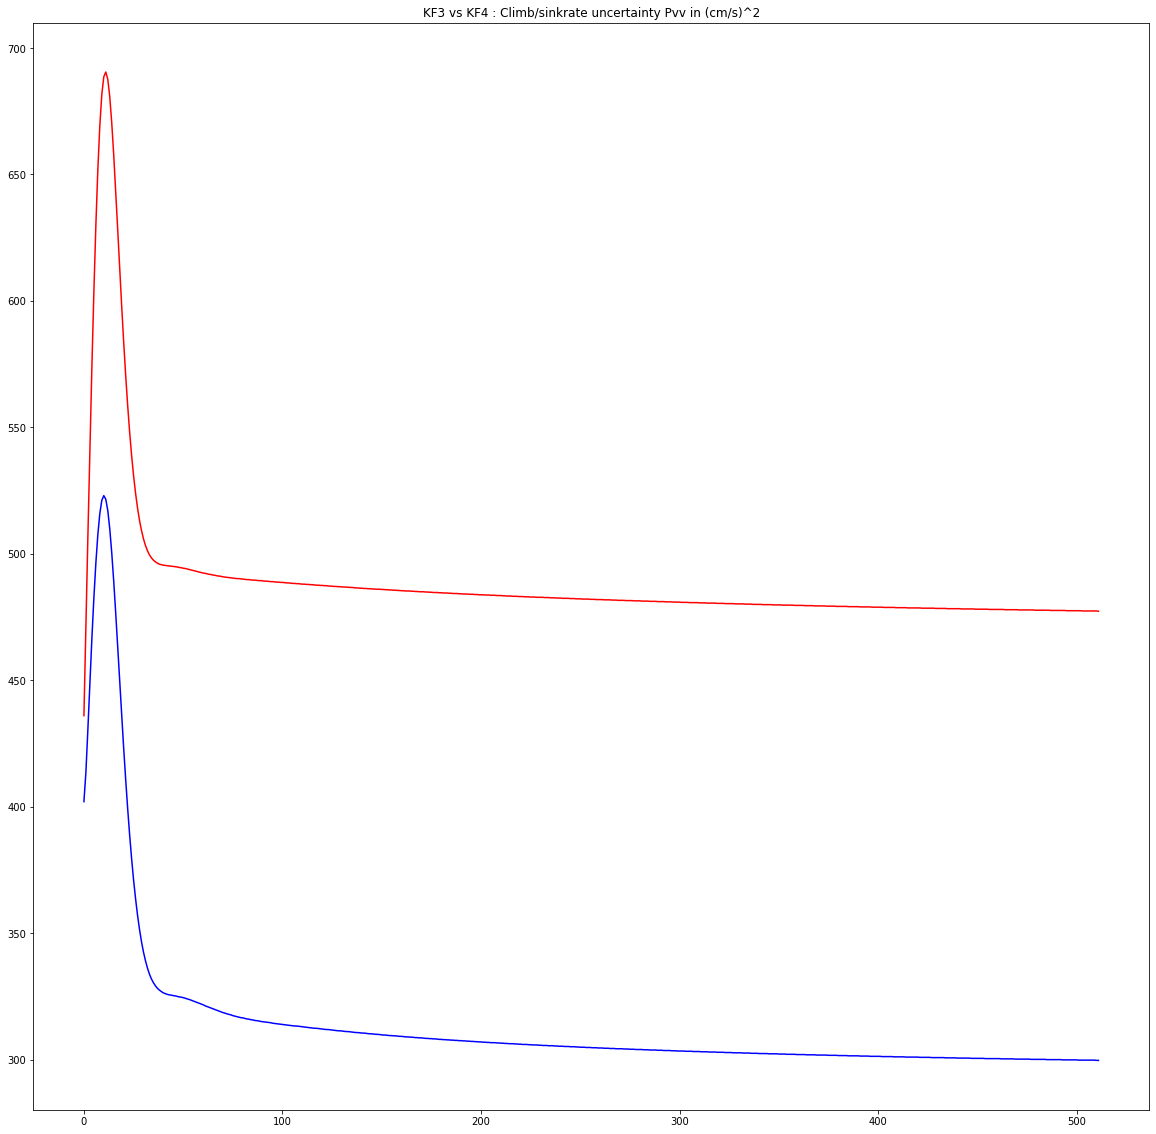

In [13]:
plt.plot(Pvv_kf3, color='red')
plt.plot(Pvv_kf4, color='blue')
plt.title('KF3 vs KF4 : Climb/sinkrate uncertainty Pvv in (cm/s)^2')
plt.show()

# Pzz and Pvv after 512 samples

|  | Pzz | Pvv |
| --- | --- | --- |
| KF3 | 16.7  | 477.3 |
| KF4 | 14.3 | 299.7 |

The KF4 algorithm has significantly lower climb/sinkrate uncertainty, which is reflected in the variometer audio feedback.